In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

left_address = r'C:\Users\Oliver\Desktop\Homework\2020\2 - Fall 2020\CISC 642 - Computer Vision\PR2\left.png'
right_address = r'C:\Users\Oliver\Desktop\Homework\2020\2 - Fall 2020\CISC 642 - Computer Vision\PR2\right.png'


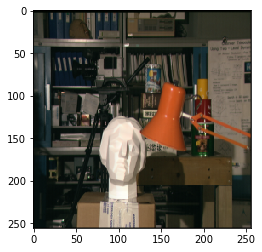

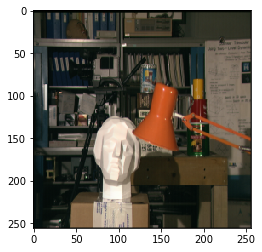

In [55]:
img_L = cv2.imread(left_address,1)
img_R = cv2.imread(right_address,1)

img_L = cv2.cvtColor(img_L, cv2.COLOR_BGR2RGB)
img_R = cv2.cvtColor(img_R, cv2.COLOR_BGR2RGB)

n_pow = 8
img_L = cv2.resize(img_L, (2**n_pow, 2**n_pow))
img_R = cv2.resize(img_R, (2**n_pow,2**n_pow))

plt.imshow(img_L)
plt.show()
plt.imshow(img_R)
plt.show()


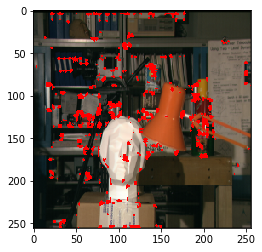

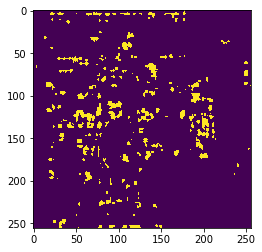

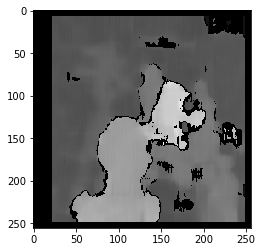

In [3]:
def get_corners(img):

    img_L = img.copy()

    gray = cv2.cvtColor(img_L,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,4,5,0.04)

    # Threshold for an optimal value, it may vary depending on the image.
    corner_mask = dst>0.01*dst.max()
    img_L[corner_mask]=[0,0,255]
    return img_L, corner_mask

result, corners_mask = get_corners(img_L)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(corners_mask)
plt.show()



gray_L = cv2.cvtColor(img_L,cv2.COLOR_BGR2GRAY)
gray_R = cv2.cvtColor(img_R,cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(16, 15)
disparity = stereo.compute(gray_L, gray_R)
plt.imshow(disparity,'gray')
plt.show()


In [74]:
def compare_matrices(M1, M2, matching_score):
    if matching_score == 'SAD':
        return np.abs(np.sum(M1-M2))
    if matching_score == 'SSD':
        return np.square(np.sum(M1-M2))
    if matching_score == 'NCC':
        return np.corrcoef(M1.ravel(), M2.ravel())[0,1]

def get_disparity(img2, i, j, pixels, w_size, matching_score):
    
    disparity_list = []
    for k in range(w_size, j):
        img_2_pixels = img2[i-w_size:i+w_size, k-w_size: k+w_size]
        disparity_list.append(compare_matrices(pixels, img_2_pixels, matching_score))
    if len(disparity_list) == 0:
        return 0
    return j - np.argmax(disparity_list)
        

def get_chosen_disparity(image_1, image_2, window_size, matching_score, choice):

    if choice == 0:
        
        #Convert images to black and white
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

        #Pad the images
        w_size = (window_size - 1) // 2
        img = cv2.copyMakeBorder(image_1, w_size, w_size, w_size, w_size,cv2.BORDER_CONSTANT,value=[0,0,0])
        img2 = cv2.copyMakeBorder(image_2, w_size, w_size, w_size, w_size,cv2.BORDER_CONSTANT,value=[0,0,0])
        
        disparity_array = np.zeros(img.shape)

        for i in range(w_size, img.shape[0] - w_size):
            for j in range(w_size, img.shape[1] - w_size):
                pixels = img[i-w_size:i+w_size,j-w_size:j+w_size]
                disparity_array[i,j] = get_disparity(img2, i,j, pixels, w_size, matching_score)
        return disparity_array[w_size:disparity_array.shape[0] - w_size,\
                               w_size:disparity_array.shape[1] - w_size]
    
    if choice == 1:
        
        w_size = (window_size - 1) // 2
        img = cv2.copyMakeBorder(image_1, w_size, w_size, w_size, w_size,cv2.BORDER_CONSTANT,value=[0,0,0])
        img2 = cv2.copyMakeBorder(image_2, w_size, w_size, w_size, w_size,cv2.BORDER_CONSTANT,value=[0,0,0])
        
        disparity_array = np.zeros(img.shape)

        _, corners_mask_L = get_corners(img)

        corners_indices = []
        
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if corners_mask_L[i,j] == True:
                    corners_indices.append((i,j))
                    
        for (i,j) in corners_indices:
            pixels = img[i-w_size:i+w_size,j-w_size:j+w_size]
            #center = pixels[w_size, w_size]
            disparity_array[i,j] = get_disparity(img2, i,j, pixels, w_size, matching_score)
        return disparity_array[w_size:disparity_array.shape[0] - w_size,\
                               w_size:disparity_array.shape[1] - w_size]

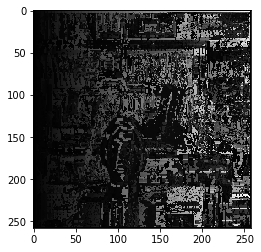

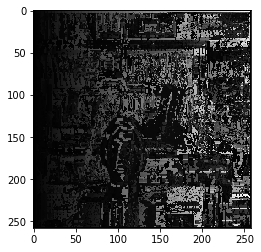

c:\python3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\python3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


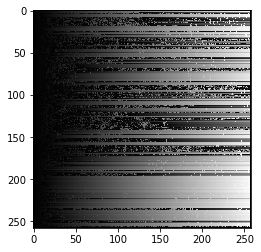

In [9]:
region_disparity_SAD = get_region_disparity(img_L, img_R, window_size = 3, matching_score = 'SAD')
plt.imshow(region_disparity_SAD, cmap='gray')
plt.show()

region_disparity_SSD = get_region_disparity(img_L, img_R, window_size = 3, matching_score = 'SSD')
plt.imshow(region_disparity_SSD, cmap='gray')
plt.show()

region_disparity_NCC = get_region_disparity(img_L, img_R, window_size = 3, matching_score = 'NCC')
plt.imshow(region_disparity_NCC, cmap='gray')
plt.show()


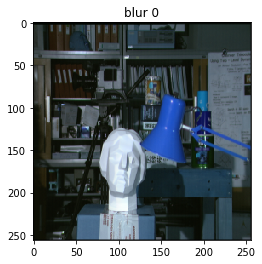

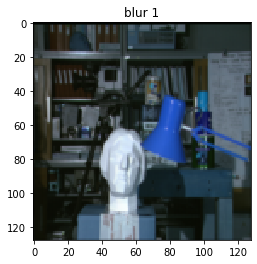

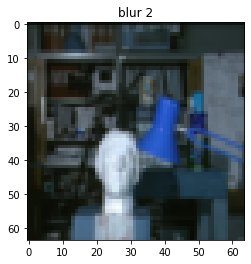

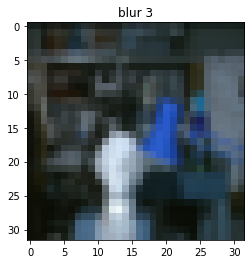

In [10]:
def blurs_function(img, n, m):
    blur_list = [img]
    for i in range(1,n+1):
        if m == 0:
            blur_list.append(cv2.GaussianBlur(blur_list[-1], (3,3), 1)[::2, ::2])
        if m == 1:
            blur_list.append(cv2.GaussianBlur(blur_list[-1], (9,9), 100))
            
        
    return blur_list


blurs = blurs_function(img_L, 3, m = 0)
for i in range(len(blurs)):
    plt.imshow(blurs[i])
    plt.title('blur {}'.format(i))
    plt.show()

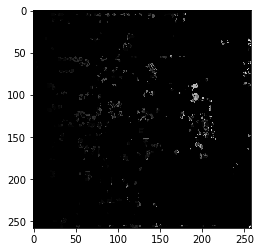

In [12]:
feature_disparity = get_feature_disparity(img_L, img_R, window_size = 3, matching_score = 'SSD')
plt.imshow(feature_disparity.astype(np.uint8))
plt.show()

In [16]:
def blurs_function(img, n, m):
    blur_list = [img]
    for i in range(1,n+1):
        if m == 0:
            blur_list.append(cv2.GaussianBlur(blur_list[-1], (3,3), 1)[::2, ::2])
        if m == 1:
            blur_list.append(cv2.GaussianBlur(blur_list[-1], (9,9), 100))
    return blur_list


def validity_check(img1, img2):
    I1 = img1.astype(np.uint8)
    I2 = img2.astype(np.uint8)
    new_img = np.zeros(I1.shape)
    for i in range(I1.shape[0]):
        for j in range(I1.shape[1]):
            if img1[i,j] != img2[i,j]:
                new_img[i,j] = 0
            else:
                new_img[i,j] = I1[i,j]
    return new_img

def propagate_disparity(disparity):
    new_img = np.zeros((disparity.shape[0]*2,
                        disparity.shape[1]*2))
    new_img[0::2, 0::2] = disparity
    new_img[1::2, 1::2] = disparity
    new_img[0::2, 1::2] = disparity
    new_img[1::2, 0::2] = disparity
    return 2 * new_img

def averaging(img):
    kernel = np.ones((5, 5)) / 25
    averaged_img = cv2.filter2D(img, -1, kernel)
    return averaged_img

In [75]:
blurs_L = blurs_function(img_L, 3, m = 0)
blurs_R = blurs_function(img_R, 3, m = 0)

blurs_L.reverse()
blurs_R.reverse()

choices = [0,0,0,0]
matchings = ['SSD', 'SSD', 'SSD', 'SSD']
window_sizes = [3,3,3,3]

disparities_L = [get_chosen_disparity(blurs_L[i], blurs_R[i],
                        window_size = window_sizes[i],
                        matching_score = matchings[i], choice = choices[i]) for i in range(len(blurs_L))]

disparities_R = [get_chosen_disparity(blurs_R[i], blurs_L[i],
                        window_size = window_sizes[i],
                        matching_score = matchings[i], choice = choices[i]) for i in range(len(blurs_L))]



In [90]:
valids = [validity_check(disparities_L[i], disparities_R[i]) for i in range(len(choices))]
averages = [averaging(valids[i]) for i in range(len(choices))]
propagated = propagate_disparity(averages[0])

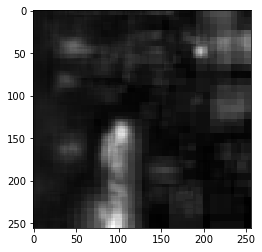

In [99]:
final_propagated = propagated.copy()
for i in range(len(choices) - 1):
    final_propagated += averages[i+1]
    final_propagated = propagate_disparity(final_propagated)
    
plt.imshow(final_propagated, cmap = 'gray')
plt.show()